# Downloading Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vtu11943/cat-and-dog")

print("Path to dataset files:", path)

100%|██████████| 218M/218M [00:02<00:00, 78.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vtu11943/cat-and-dog/versions/1


In [2]:
import shutil
import os

# Define the source and destination paths
source_path = '/root/.cache/kagglehub/datasets/vtu11943/cat-and-dog/versions/1/dataset'
destination_path = '/content/'

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Move the dataset folder
shutil.move(source_path, destination_path)

print(f"Dataset moved from {source_path} to {destination_path}")

Dataset moved from /root/.cache/kagglehub/datasets/vtu11943/cat-and-dog/versions/1/dataset to /content/


# Verifying Dataset

In [ ]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'dataset'.
There are 2 directories and 0 images in 'dataset/training_set'.
There are 0 directories and 4000 images in 'dataset/training_set/dogs'.
There are 0 directories and 4000 images in 'dataset/training_set/cats'.
There are 0 directories and 2 images in 'dataset/single_prediction'.
There are 2 directories and 0 images in 'dataset/test_set'.
There are 0 directories and 1000 images in 'dataset/test_set/dogs'.
There are 0 directories and 1000 images in 'dataset/test_set/cats'.


In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (272, 414, 3)


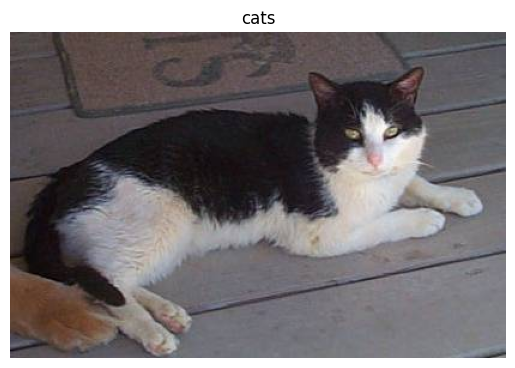

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="dataset/training_set/",
                        target_class="cats")

# Model 0: Random Forest

In [3]:
# Import necessary libraries
import os
import numpy as np
from skimage import io, color, transform, feature
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

train_dir = 'dataset/training_set'
test_dir = 'dataset/test_set'

# Define image properties
image_size = (128, 128)  # Resize images to 128x128 pixels
orientations = 9  # Number of orientation bins for HOG
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# Function to extract HOG features and labels from a directory
def extract_features_labels(directory):
    features = []
    labels = []

    for label_dir in os.listdir(directory):
        label_path = os.path.join(directory, label_dir)
        if not os.path.isdir(label_path):
            continue

        label = label_dir  # 'cats' or 'dogs'
        print(f"Processing {label} images...")

        # Loop over the images in the class directory
        image_files = os.listdir(label_path)
        for filename in tqdm(image_files):
            file_path = os.path.join(label_path, filename)
            try:
                image = io.imread(file_path)
                # Convert to grayscale
                if len(image.shape) == 3:
                    image = color.rgb2gray(image)
                # Resize the image
                image_resized = transform.resize(image, image_size, anti_aliasing=True)
                # Extract HOG features
                hog_features = feature.hog(
                    image_resized,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    block_norm='L2-Hys',
                    visualize=False,
                    feature_vector=True,
                )
                # Append features and label
                features.append(hog_features)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue  # Skip corrupted images
    return np.array(features), np.array(labels)

# Extract features and labels for training and testing sets
print("Extracting features from training set...")
X_train, y_train = extract_features_labels(train_dir)
print("Extracting features from testing set...")
X_test, y_test = extract_features_labels(test_dir)

# Encode labels ('cats' and 'dogs') to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Create and train Random Forest classifier
print("Training Random Forest classifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train_encoded)

# Predict on test set
print("Predicting on test set...")
y_pred = rf_clf.predict(X_test)

# Evaluate the classifier
print("\nEvaluation Results:")
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

Extracting features from training set...
Processing cats images...


100%|██████████| 4000/4000 [01:00<00:00, 66.04it/s]


Processing dogs images...


100%|██████████| 4000/4000 [01:01<00:00, 64.99it/s]


Extracting features from testing set...
Processing cats images...


100%|██████████| 1000/1000 [00:15<00:00, 66.04it/s]


Processing dogs images...


100%|██████████| 1000/1000 [00:15<00:00, 66.13it/s]


Training Random Forest classifier...
Predicting on test set...

Evaluation Results:
Accuracy: 0.6975
Confusion Matrix:
[[757 243]
 [362 638]]

Classification Report:
              precision    recall  f1-score   support

        cats       0.68      0.76      0.71      1000
        dogs       0.72      0.64      0.68      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



In [ ]:
from joblib import dump
dump(rf_clf, 'random_forest.joblib')

['random_forest.joblib']

# Model 1: CNN (Tiny VGG)

In [3]:
import tensorflow as tf

# Set the seed
tf.random.set_seed(42)

# Function to preprocess images
def preprocess_image(image, label):
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0  # Normalize to [0,1]
    return image, label

# Setup the train and test directories
train_dir = "dataset/training_set/"
test_dir = "dataset/test_set/"

# Load data using tf.data.Dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    image_size=(128, 128),
    batch_size=32,
    seed=42
).map(preprocess_image)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='binary',
    image_size=(128, 128),
    batch_size=32,
    seed=42
).map(preprocess_image)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
# CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [5]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [6]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=valid_data)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5334 - loss: 0.6873 - val_accuracy: 0.6385 - val_loss: 0.6453
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6648 - loss: 0.6305 - val_accuracy: 0.6870 - val_loss: 0.5974
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.7180 - loss: 0.5699 - val_accuracy: 0.6955 - val_loss: 0.6176
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.7572 - loss: 0.5120 - val_accuracy: 0.7030 - val_loss: 0.5610
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.7797 - loss: 0.4676 - val_accuracy: 0.7195 - val_loss: 0.5771


In [7]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8410)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,411 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,265 (133.85 KB)

 Trainable params: 11,421 (44.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,844 (89.24 KB)

In [8]:
# Save the model
model_1.save("model_1.keras")

# Model 2: Overfitted Model

In [9]:
# Overfitted Model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, padding='valid', activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [11]:
# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=valid_data)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.5140 - loss: 1.2611 - val_accuracy: 0.5860 - val_loss: 0.6727
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.6047 - loss: 0.6651 - val_accuracy: 0.5985 - val_loss: 0.6632
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6875 - loss: 0.5966 - val_accuracy: 0.6330 - val_loss: 0.6864
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7707 - loss: 0.4786 - val_accuracy: 0.6445 - val_loss: 0.7360
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8622 - loss: 0.3239 - val_accuracy: 0.6320 - val_loss: 0.9272


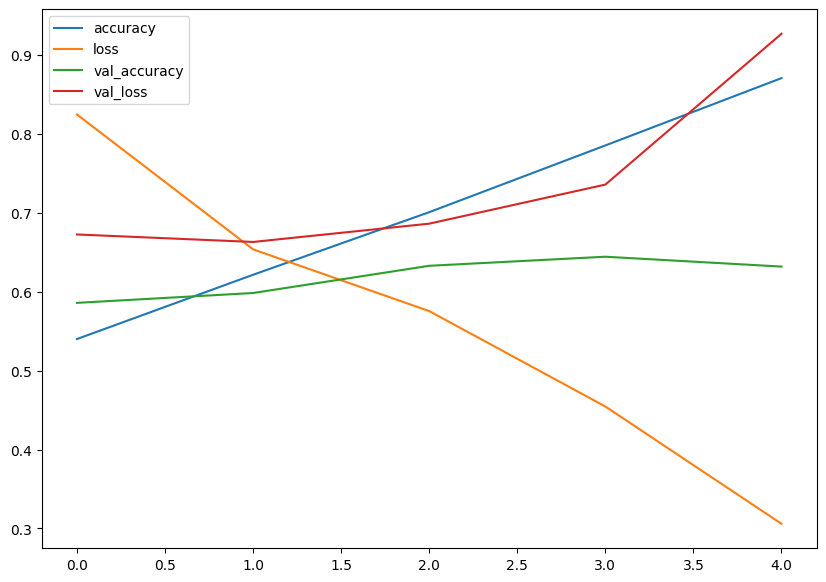

In [12]:
import pandas as pd
pd.DataFrame(history_2.history).plot(figsize=(10, 7));

In [13]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

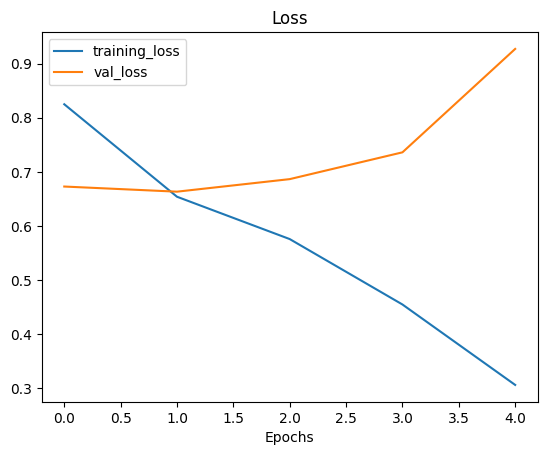

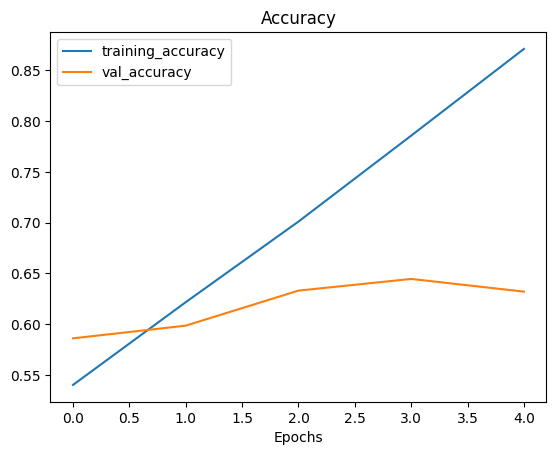

In [14]:
# Check out the loss curves of model_4
plot_loss_curves(history_2)

In [15]:
# Check out our model's architecture
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 124, 124, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 122, 122, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 148840)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         148,841 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,825 (1.73 MB)

 Trainable params: 150,941 (589.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 301,884 (1.15 MB)

# Model 3: Reduced Overfitting

- Increase the number of convolutional layers
- Increase the number of convolutional filters
- Add another dense layer to the output of our flattened layer

In [16]:
# Reduced Overfitting
model_3 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [18]:
# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=valid_data)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.5405 - loss: 0.6821 - val_accuracy: 0.5815 - val_loss: 0.6674
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6641 - loss: 0.6129 - val_accuracy: 0.7000 - val_loss: 0.5705
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7125 - loss: 0.5574 - val_accuracy: 0.7125 - val_loss: 0.5648
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.7410 - loss: 0.5265 - val_accuracy: 0.7315 - val_loss: 0.5431
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.7402 - loss: 0.5092 - val_accuracy: 0.7255 - val_loss: 0.5569


In [19]:
# Check out the model architecture
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 126, 126, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 61, 61, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1960)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,185 (47.60 KB)

 Trainable params: 4,061 (15.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,124 (31.74 KB)

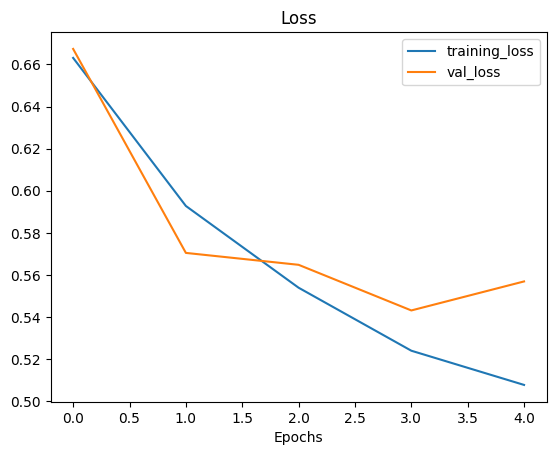

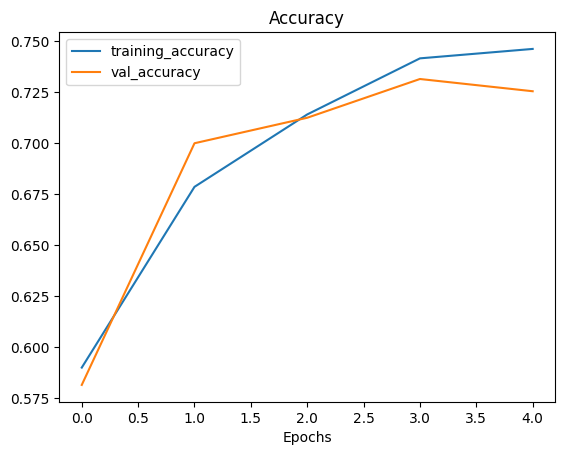

In [20]:
# Plot loss curves of model_3 results
plot_loss_curves(history_3)

In [21]:
model_3.save("model_3.keras")

# Model 4: Data Augmented Model

In [22]:
augmented_data = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2)
])

In [23]:
train_augmented_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    image_size=(128, 128),
    batch_size=32,
    seed=42,
    shuffle=True
).map(lambda x, y: (augmented_data(x, training=True), y))

Found 8000 files belonging to 2 classes.


In [24]:
model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
# Fit the model
history_4 = model_4.fit(train_augmented_data,
                        epochs=5,
                        validation_data=valid_data)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 228ms/step - accuracy: 0.5208 - loss: 0.6910 - val_accuracy: 0.5755 - val_loss: 0.6673
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.5909 - loss: 0.6720 - val_accuracy: 0.5620 - val_loss: 0.7039
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.6098 - loss: 0.6593 - val_accuracy: 0.6335 - val_loss: 0.6411
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 223ms/step - accuracy: 0.6328 - loss: 0.6462 - val_accuracy: 0.6485 - val_loss: 0.6347
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 231ms/step - accuracy: 0.6509 - loss: 0.6342 - val_accuracy: 0.6805 - val_loss: 0.6096


In [27]:
# Check out the model architecture
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1960)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,185 (47.60 KB)

 Trainable params: 4,061 (15.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,124 (31.74 KB)

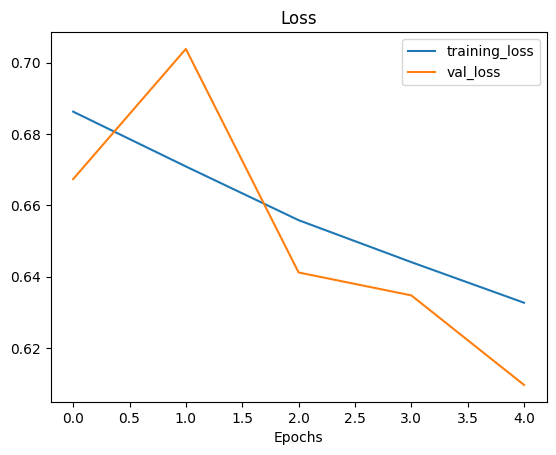

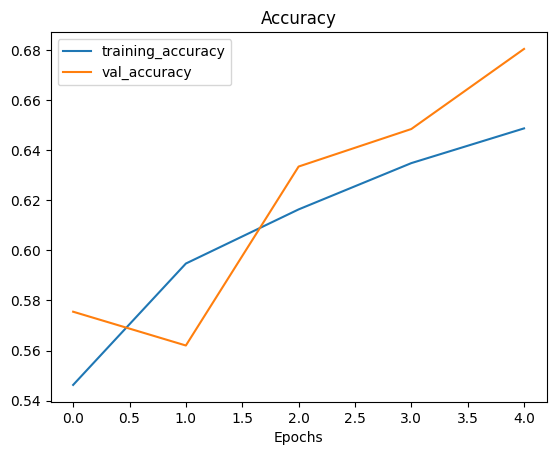

In [28]:
# Plot loss curves of model_3 results
plot_loss_curves(history_4)